In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
image_folder_path = "C:/Users/louis/github_vs/MA2---Towards-real-time-support-for-a-suicide-prevention-hotline-operators-"
categories = ['Labeling and mislabeling', 'Catastrophizing',
       'Dichotomous Reasoning', 'Emotional Reasoning',
       'Disqualifying the Positive', 'Magnification and Minimization',
       'Mental Filtering', 'Mindreading', 'Fortune-telling',
       'Overgeneralizing', 'Personalizing','Should statements']
df_all = pd.read_csv(image_folder_path+'/df_all_nochat.tsv', sep='\t')
df_all.drop(['id'],axis=1,inplace=True)

In [3]:
bins_nb = 100
bins = np.linspace(0, 1, bins_nb)

all_sums_client = np.zeros((bins_nb,len(categories)))
all_sums_employee = np.zeros((bins_nb,len(categories)))


max = df_all.groupby("event_id").transform("max")
new_df = df_all.drop(['event_id','sec_since_start'],axis=1)
new_df['sec_since_start_norm'] = df_all['sec_since_start']/max['sec_since_start'] # normalize the time by the conversation length
groups = new_df.groupby(np.digitize(new_df.sec_since_start_norm, bins)) # grouping per time bin

for time, group in groups:
    time = time-1
    for name, user_group in group.groupby("user_handle"):
        user_group.drop(['user_handle','sec_since_start_norm'],axis=1,inplace=True)
        sums = np.array(user_group.sum(),dtype=np.float64) # cumulative sum of the CDS per time bin
        if 'client' in name:  all_sums_client[time] = all_sums_client[time] + sums # summing with the previous data folders
        if 'employee' in name: all_sums_employee[time] = all_sums_employee[time] + sums # summing with the previous data folders

print("-------------------------------------------------------")

-------------------------------------------------------


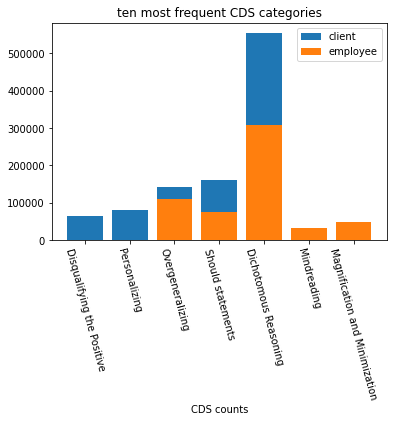

In [4]:
# comparison of the most frequent CDS used by employees vs clients
arg_sorted_client = np.argsort(all_sums_client.sum(axis =0),axis=0)
sorted_vals_client = np.sort(all_sums_client.sum(axis =0),axis=0)
arg_sorted_employee = np.argsort(all_sums_employee.sum(axis =0),axis=0)
sorted_vals_employee = np.sort(all_sums_employee.sum(axis =0),axis=0)

plt.figure()
plt.title("ten most frequent CDS categories")
plt.bar([categories[index] for index in arg_sorted_client[-5:]],sorted_vals_client[-5:],label='client')
plt.bar([categories[index] for index in arg_sorted_employee[-5:]],sorted_vals_employee[-5:],label='employee')
plt.xlabel('CDS counts')
plt.xticks(rotation = -75)
plt.legend()

In [5]:
max_sums_client = np.argmax(all_sums_client,axis=1)
sums_sums_client = np.sum(all_sums_client,axis=1) 
max_sums_employee = np.argmax(all_sums_employee,axis=1)
sums_sums_employee = np.sum(all_sums_employee,axis=1)

df_employee = pd.DataFrame(data = {'max_time':max_sums_employee, 'sum':sums_sums_employee, 'bins':bins});
df_client = pd.DataFrame(data = {'max_time':max_sums_client, 'sum':sums_sums_client, 'bins':bins});

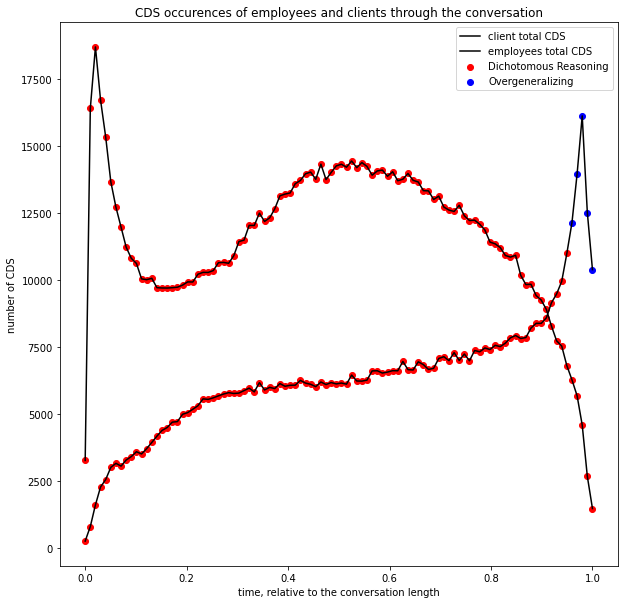

In [6]:
# printing the most frequent cds over time
unique_cds = np.unique(np.append(np.unique(max_sums_client),np.unique(max_sums_employee)))
cds_colors = dict(zip(unique_cds, ['red', 'blue','green','pink','black','m','black']))
plt.figure(figsize=(10,10))
plt.title("CDS occurences of employees and clients through the conversation")
plt.plot(bins, sums_sums_client, label='client total CDS',c='black')
for name, group in df_client.groupby("max_time"):
    plt.scatter(group['bins'],group['sum'],c=cds_colors[name])
plt.plot(bins, sums_sums_employee, label='employees total CDS',c='black')

for name, group in df_employee.groupby("max_time"):
    plt.scatter(group['bins'],group['sum'],label=categories[name],c=cds_colors[name])
    
plt.xlabel('time, relative to the conversation length')
plt.ylabel('number of CDS')

plt.legend()

In [7]:
image_folder_path = "C:/Users/louis/github_vs/MA2---Towards-real-time-support-for-a-suicide-prevention-hotline-operators-"

df_all_prechat = pd.read_csv(image_folder_path+'/df_all_prechat.tsv', sep='\t')
df_all_prechat.drop(['id','sec_since_start'],axis=1,inplace=True)

In [8]:
# computing the correlations between cdss and states
states = ['negative','postive']

all_tops =[]

for i,state in enumerate(states):  
                        
    user_goups = df_all_prechat.groupby(['user_handle'])
    
    for name, user_group in user_goups:
            
        user_state = user_group[[state,'event_id']].groupby('event_id').max()
        user_group = user_group.drop(states,axis=1).groupby('event_id').sum()
        user_group[state] =user_state
        
        all_corrs =user_group.corr()[state][:-1].dropna()
        order = all_corrs.abs().sort_values(ascending=False).index
        all_corrs = all_corrs[order]

        print("The most correlated responses of",name,'in',state,"state are:")
        top = all_corrs.head(10)
        print(top)
        all_tops.append(top)
        print("-------------------------------------------------------")              


The most correlated responses of client in negative state are:
the best                -0.106506
no one/nobody            0.096861
we know                 -0.092812
everything               0.086353
we do not know          -0.084635
Dichotomous Reasoning    0.084058
we think                -0.073321
nothing.1                0.072279
he never                -0.064459
everyone/everybody       0.063515
Name: negative, dtype: float64
-------------------------------------------------------
The most correlated responses of employee in negative state are:
he always                -0.103620
she always/they always   -0.088744
not a single             -0.086265
completely.1              0.059394
he thinks                -0.057574
Should statements         0.056123
she thinks               -0.055930
no one/nobody             0.054890
everybody                 0.053485
must                      0.053327
Name: negative, dtype: float64
-------------------------------------------------------
The most

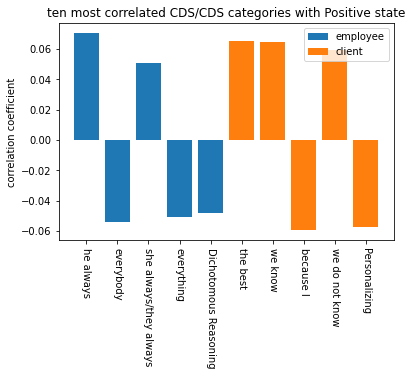

In [9]:
plt.figure()
plt.title("ten most correlated CDS/CDS categories with Positive state")

nb =5
plt.bar(all_tops[3][:nb].index,all_tops[3][:nb].values,label='employee')
plt.bar(all_tops[2][:nb].index,all_tops[2][:nb].values,label='client')
plt.ylabel('correlation coefficient')
plt.xticks(rotation = -90)
plt.legend()

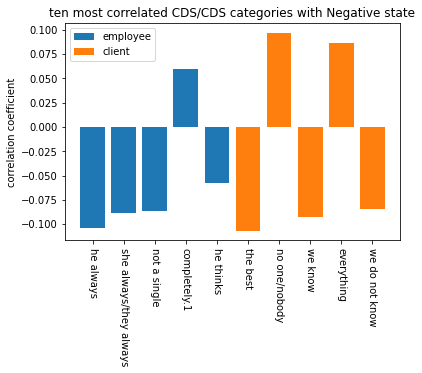

In [10]:
plt.figure()
plt.title("ten most correlated CDS/CDS categories with Negative state")

nb =5
plt.bar(all_tops[1][:nb].index,all_tops[1][:nb].values,label='employee')
plt.bar(all_tops[0][:nb].index,all_tops[0][:nb].values,label='client')
plt.ylabel('correlation coefficient')
plt.xticks(rotation = -90)
plt.legend()